# Microstrip Transmission Line S-Parameter Analysis Using scikit-rf

**Author**: Nicolas Ramos  
**Purpose**: Demonstrate basic RF PCB stub simulation and S-parameter analysis using Python and the `scikit-rf` library.  

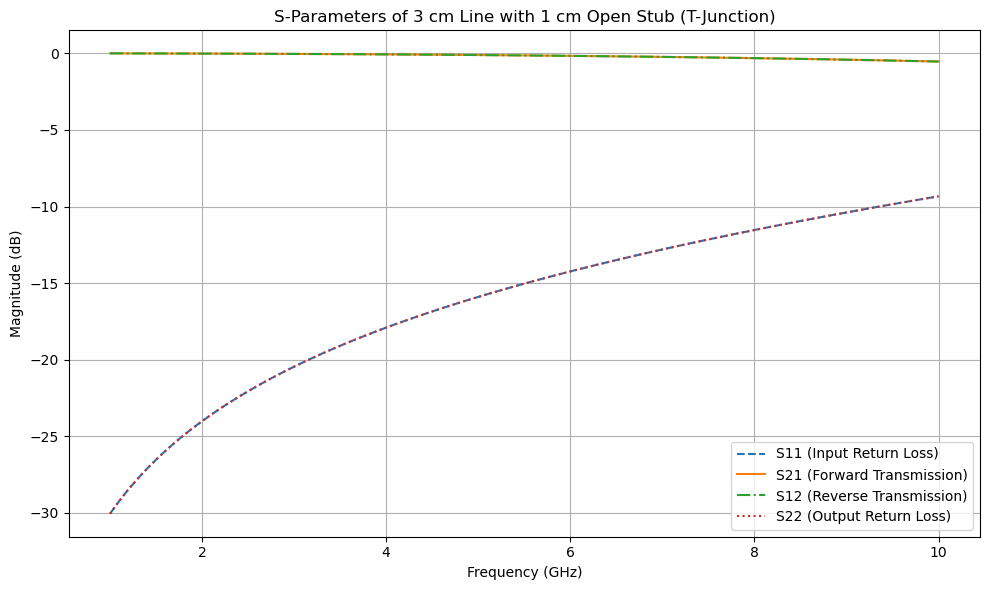

Max Return Loss (S11 = S22, worst case reflection): -9.33 dB
Max Insertion Loss (S21 = S12, best case transmission): -0.00 dB
Best impedance match is at 1.00 GHz with a return loss of -30.05 dB


In [44]:
import skrf as rf
import numpy as np
import matplotlib.pyplot as plt
from skrf.media import DefinedGammaZ0
from skrf.network import connect 


# Creates a Frequency object representing a sweep from 1 GHz to 10 GHz with 201 points.
freq = rf.Frequency(1, 10, 201, unit='GHz')

# Defines a complex propagation constant for a lossless line. The frequency is
# scaled by 1e-9 to create a synthetic phase delay. This determines how much phase
# shift happens per unit length.
gamma = 1j * 2 * np.pi * freq.f * 1e-9

# Sets characteristic transmission line impedance.
z0 = 50
# Defines a custom transmission medium based on the value of gamma with specific
# propagation behavior.
medium = DefinedGammaZ0(frequency=freq, gamma=gamma, z0=z0)


# Main transmission line parts. They use the custom transmission medium definition
# to create 1.5 cm long 2-port transmission lines. They model the main input 
# (pre_line) and output (post_line) sections of the network.
pre_line = medium.line(d=0.015, unit='m', name='pre_line')  
post_line = medium.line(d=0.015, unit='m', name='post_line') 


# Creates a 1 cm transmission line representing the physical stub structure
# (i.e. trace branching off the main line). 
stub_line = medium.line(d=0.01, unit='m', name='stub_line')

# Describes an open end network (1-port network with S = 1 for reflection)
open_end = rf.Network(frequency=freq, s=np.ones((len(freq), 1, 1)), z0=z0, name='open_end')

# Cascades the stub line with the open end to form the complete stub
stub = stub_line ** open_end
stub.name = 'stub'


# This is the ideal T-junction definition: a normalized 3×3 S-matrix representing an ideal, 
# symmetric, 3-port lossless network. Each diagonal term (reflection coefficient) is –1/3, 
# meaning that one-third of the incident voltage wave at any port is reflected back with a 
# 180-degree phase shift. Each off-diagonal term (transmission coefficient) is 2/3, meaning 
# that two-thirds of the incident voltage wave is equally divided and transmitted to the other 
# two ports. This ensures power conservation in a perfectly matched and lossless system.
s_tee_ideal = np.array([
    [-1/3,  2/3,  2/3],
    [ 2/3, -1/3,  2/3],
    [ 2/3,  2/3, -1/3]
])

# Extends the S-matrix for the ideal T-junction across all frequencies to ensure compatibility
# with scikit-rf.
s_tee_matrix = np.tile(s_tee_ideal, (len(freq), 1, 1))

# Creates a 3-port Network object representing the physical junction where port 0 connects to
# the pre_line segment, port 1 connects to the stub segment, and port 2 connects to the 
# post_line segment.
ideal_tee = rf.Network(frequency=freq, s=s_tee_matrix, z0=z0, name='ideal_tee')


# Connects the output of the pre_line segment (port 1) to port 0 of ideal T-junction.
connected_part1 = connect(pre_line, 1, ideal_tee, 0)
connected_part1.name = 'pre_line_plus_tee'

# Connects the stub segment to port 1 of T-junction, making a shunt open stub configuration.
connected_part2 = connect(connected_part1, 1, stub, 0)
connected_part2.name = 'pre_line_tee_plus_stub'

# Connects port 2 (now considered port 1) of the T-junction to the input of the post_line.
final_network_system = connect(connected_part2, 1, post_line, 0)
final_network_system.renumber(from_ports=[0, 1], to_ports=[1, 0])
final_network_system.name = 'final_system_with_stub'



# Extracts the reflection at the input (s11) and the transmission from port 0 to port 1 (s21).
# Extracts the reflection at the output (s22) and the transmission from port 1 to port 0 (s12).
s11 = final_network_system.s[:, 0, 0]
s21 = final_network_system.s[:, 1, 0] 
s12 = final_network_system.s[:, 0, 1] 
s22 = final_network_system.s[:, 1, 1]  

# Converts frequencies from Hz to GHz for plotting.
freqs = final_network_system.f / 1e9 


# Plotting S-parameters
eps = 1e-12 # Small epsilon to prevent issues with log10(0) for very small magnitudes
plt.figure(figsize=(10, 6)) 
plt.plot(freqs, 20 * np.log10(np.abs(s11) + eps), label='S11 (Input Return Loss)', linestyle='--')
plt.plot(freqs, 20 * np.log10(np.abs(s21) + eps), label='S21 (Forward Transmission)', linestyle='-')
plt.plot(freqs, 20 * np.log10(np.abs(s12) + eps), label='S12 (Reverse Transmission)', linestyle='-.')
plt.plot(freqs, 20 * np.log10(np.abs(s22) + eps), label='S22 (Output Return Loss)', linestyle=':')
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.title("S-Parameters of 3 cm Line with 1 cm Open Stub (T-Junction)")
plt.grid(True)
plt.legend() 
plt.tight_layout()
plt.show()
print("Max Return Loss (S11 = S22, worst case reflection): {:.2f} dB".format(20 * np.log10(np.max(np.abs(s11)))))
print("Max Insertion Loss (S21 = S12, best case transmission): {:.2f} dB".format(20 * np.log10(np.max(np.abs(s21)))))
best_match_freq_idx = np.argmin(np.abs(s11))
best_match_freq = freqs[best_match_freq_idx]
best_return_loss_db = 20 * np.log10(np.abs(s11[best_match_freq_idx]))
print("Best impedance match is at {:.2f} GHz with a return loss of {:.2f} dB".format(
    best_match_freq, best_return_loss_db
))
# The reason S11 = S22 and S21 = S12 is because the network is both reciprocal and symmetric, meaning 
# signal transmission is identical in both directions. Symmetry comes from the physical layout, i.e. the 
# input and output transmission lines are the same length, and the open stub is centered between them, 
# so reflections and transmission paths are electrically identical whether the signal enters from port 0 or 1.
# Find frequency of best match (min return loss)

## Conclusion

This simulation models a high-frequency PCB interconnect as a symmetric transmission line with a central open-circuited stub using scikit-rf. While the propagation is abstracted through a generic transmission line model, the configuration captures the behavior of lossless microstrip traces commonly used in RF PCB design. The resulting S-parameters exhibit expected RF characteristics: low insertion loss, moderate return loss, and perfect symmetry driven by the network’s reciprocal and balanced layout. Return loss analysis reveals optimal impedance matching at approximately 1.00 GHz, where it reaches –30.05 dB, indicating minimal signal reflection. This demonstrates the stub’s role as an effective frequency-selective impedance tuning element. Overall, the simulation reinforces key concepts in transmission line behavior and interconnect characterization, offering practical insight into high-frequency PCB modeling.